In [4]:
import numpy as np
import collections
import matplotlib.pyplot as plt

from scipy.special import logsumexp

import geometry
import itertools
from collections import defaultdict
import collections

from functools import reduce

from multiprocess import Pool
from functools import partial
import numpy as np
import geometry
import itertools 
from itertools import islice
import games
import cpb

import cpb_gaussian

import bpm
import random_algo

import plotly.graph_objects as go
import TSPM
import PM_DMED


import feedexp3_piccolboni
import cpb_gaussian_v2

def evaluate_parallel(nbCores, n_folds, horizon, alg, game, type, L):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    task = Evaluation(horizon, type, L)

    np.random.seed(1)
    distributions = []

    for jobid in range(n_folds):
        
        p = np.random.uniform(0, 0.2) if type == 'easy' else np.random.uniform(0.4,0.5)
        distributions.append( [p, 1-p] )


    return np.asarray(  pool.map( partial( task.eval_policy_once, alg, game ), zip(distributions ,range(n_folds)) ) ) 


class Evaluation:

    def __init__(self, horizon,type, L):
        self.type = type
        self.horizon = horizon
        self.L = L
        # self.outcome_distribution = outcome_distribution

    

    def get_outcomes(self, game, job_id):
        # self.means = runif_in_simplex( self.game.n_outcomes )
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):

        alg.reset()

        distribution, jobid = job

        np.random.seed(jobid)
        
        # outcome_distribution =  {'spam':0.05,'ham':0.95}

        outcome_distribution =  {'spam':distribution[0],'ham':distribution[1]}

        # p = get_easy() if game.mode == 'easy' else get_harsch() 
        # outcome_distribution =  {'a':p[0],'b':p[1],'c':p[2],'d':p[3],'e':p[4]}

        game.set_outcome_distribution( outcome_distribution )
        # print('optimal action', game.i_star)

        action_counter = np.zeros( (game.n_actions, self.horizon) )

        # generate outcomes obliviously
        outcomes = self.get_outcomes(game, jobid)

        buffer = []

        for t in range(self.horizon):

            # policy chooses one action
            action = alg.get_action(t)

            # Environment chooses one outcome
            outcome = outcomes[t]

            # p r i n t ( ' t ' , t , ' a c t i o n ' , a c t i o n , ' o u t c o m e ' , o u t c o m e , )

            feedback =  self.get_feedback( game, action, outcome )

            buffer.append( [action, outcome, feedback] )

            if len(buffer)>=self.L or t<game.N:
                for data in buffer:
                    action, outcome, feedback = data 
                    alg.update(action, feedback, outcome, None, t)
                buffer = []
            
            # p r i n t ( ' n u ' , a l g . n u / a l g . n )

            for i in range(game.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] + 1
                else:
                    
                    action_counter[i][t] = action_counter[i][t-1]

        regret = np.array( [ game.delta(i) for i in range(game.n_actions) ]).T @ action_counter

        return regret


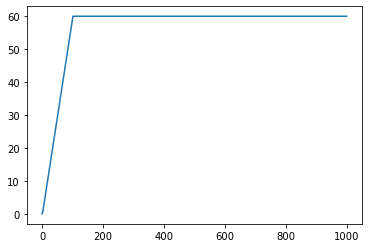

In [3]:
n_cores = 1
n_folds = 1
horizon = 1000

# np.seterr(all='raise')

# game = games.apple_tasting(False, outcome_distribution) 

game =  games.apple_tasting( False ) 

outcome_distribution = [0.2,0.8]
job = (outcome_distribution, 1 )

# print('optimal action', game.i_star)

alg = cpb.CPB(  game, horizon, 1.01) #TSPM.TSPM_alg(  game, horizon, 1)
task = Evaluation( horizon, 'easy', 100)

result = task.eval_policy_once(alg,game, job)
plt.plot(range(horizon), result)
# fig = go.Figure( )
# regret = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result,0) 
# xcoords = np.arange(0,horizon,1).tolist()

# fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='blue'), mode='lines',  name='TPSM' )) # 


In [5]:


#import ucbTSPM_v2
n_cores = 16
n_folds = 100
horizon = 2500
# outcome_distribution =  {'spam':0.05,'ham':0.95}

game = games.apple_tasting(False)


#feedexp3.FeedExp3(  game, horizon, ),
#feedexp3_v3.FeedExp3(  game, horizon, ),
#eTSPM.eTSPM_alg(  game, horizon, 1),
#TSPM.TSPM_alg(  game, horizon,), bpm.BPM(  game, horizon,  [0.5, 0.5 ], np.identity(2) ) ,

#TSPM.TSPM_alg(  game, horizon,), 
#ucbTSPM_v2.TSPM_alg(game, horizon)  

algos = [   random_algo.Random(  game, horizon, ),

            feedexp3_piccolboni.FeedExp3(  game, horizon, ),

            cpb.CPB(  game, horizon, 1.01), 
            cpb_gaussian.CPB_gaussian(  game, horizon, 1.01, True, 1/16, 10), 

            PM_DMED.PM_DMED(  game, horizon,),   

            TSPM.TSPM_alg(  game, horizon, 1),
            TSPM.TSPM_alg(  game, horizon, 0), 

            bpm.BPM(game,horizon),  ] 

colors = [  [0,0,0], [250,0,0], [0,250,0], [0,125,0], [250,0,250], [0,0,250], [0,0,125],  [0,125,125]  ]
labels = [   'random', 'Piccolboni','CBP', 'RandCBP', 'PM_DMED', 'TSPM_R1', 'TSPM_R0', 'BPM_LEAST'   ] 

fig = go.Figure(    )

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'hard')
    np.save('./results/apple_tasting/hard_{}_{}_{}'.format(horizon,n_folds, label), result)
    regret =  np.mean(result,0) 
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=False )

    )
    
fig.show(legend=True)
fig.update_yaxes(range=[0, 100] )

fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                 xaxis_title="Sequence",
                 yaxis_title="Regret",
                 margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ), 
                  font=dict(size=13,) )
fig.write_image("./hard_AT_LF.pdf")

fig.show()

Restricted license - for non-production use only - expires 2023-10-25
weights [0. 1.]
n-actions 2 n-outcomes 2 alphabet 2
n-actions 2 n-outcomes 2 alphabet 2
n-actions 2 n-outcomes 2 alphabet 2
n-actions 2 n-outcomes 2 alphabet 2


TypeError: evaluate_parallel() missing 1 required positional argument: 'L'

In [ ]:
#import ucbTSPM_v2
import cpb_gaussian_v2

n_cores = 16
n_folds = 100
horizon = 2500
# outcome_distribution =  {'spam':0.05,'ham':0.95}

game = games.apple_tasting(False)

algos = [   random_algo.Random(  game, horizon, ),

            feedexp3_piccolboni.FeedExp3(  game, horizon, ),

            cpb.CPB(  game, horizon, 1.01), 
            cpb_gaussian.CPB_gaussian(  game, horizon, 1.01, True, 1/16, 10), 

            PM_DMED.PM_DMED(  game, horizon,),   

            TSPM.TSPM_alg(  game, horizon, 1),
            TSPM.TSPM_alg(  game, horizon, 0), 

            bpm.BPM(game,horizon),  ] 

colors = [  [0,0,0], [250,0,0], [0,250,0], [0,125,0], [250,0,250], [0,0,250], [0,0,125],  [0,125,125]  ]
labels = [   'random', 'Piccolboni','CBP', 'RandCBP', 'PM_DMED', 'TSPM_R1', 'TSPM_R0', 'BPM_LEAST'   ] 

experiment_results = {}

for L in [1, 3, 10, 32, 100, 316, 1000] :
  
  fig = go.Figure( )
  final_regrets = []
  perfs = []

  for alg, color, label in zip( algos, colors, labels):
    r,g,b = color
    result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'easy', L)
    np.save('./results/apple_tasting/easy_{}_{}_{}'.format(horizon,n_folds, label), result)
    final_regrets.append( result[:,-1] )
    regret =  np.mean(result, 0) 
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std
    perfs.append( (regret[-1], std[-1]) )

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                                        line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=False )  )
        
  #fig.show(legend=True)
  fig.update_yaxes(range=[0, 30] )
  fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                        xaxis_title="Sequence", yaxis_title="Regret",  margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ),   font=dict(size=13,) )
  fig.write_image("./easy_LE_{}.pdf".format(L) )

  #fig.show()

  final_regrets = np.array(final_regrets)
  final = [ ( np.argmin(final_regrets[:,i]), i) for i in range(n_folds) ]

  experiment_results[L] = perfs

print(experiment_results)